In [1]:
import torch 
from torch import nn 
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from Utils.helper_functions import accuracy_fn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [3]:
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])

caltech_data = datasets.ImageFolder(
    root='Data/caltech256/256_ObjectCategories/',
    transform=data_transform
)

print(
    len(caltech_data), 
    type(caltech_data), 
    len(caltech_data.classes), 
    sep='\n'
)

30608
<class 'torchvision.datasets.folder.ImageFolder'>
257


In [4]:
NUM_CLASSES = len(caltech_data.classes)

In [5]:
# unable to access gpu. so training with only 20% of data

def custom_train_test_split(dataset, test_split=0.8):
    train_idx, test_idx = train_test_split(
        list(range(len(dataset))), 
        test_size=test_split
    )
    
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, test_idx)
    
    return datasets

caltech_data = custom_train_test_split(caltech_data)

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    caltech_data['train'],
    batch_size=32,
    shuffle=True,
    drop_last=True
)
test_dataloader = torch.utils.data.DataLoader(
    caltech_data['test'],
    batch_size=32
)

print(f"Length of Train DataLoader: {len(train_dataloader)}, \
Batch Size: {train_dataloader.batch_size}")
print(f"Length of Test DataLoader: {len(test_dataloader)}, \
Batch Size: {test_dataloader.batch_size}")

Length of Train DataLoader: 191, Batch Size: 32
Length of Test DataLoader: 766, Batch Size: 32


In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

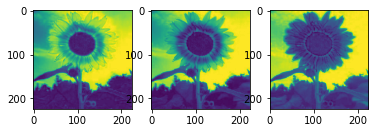

In [8]:
# visualize data 

# torch.manual_seed(42)

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
cnt = 1

for index in range(3):
    plt.subplot(1, 3, cnt)
    cnt += 1
    plt.imshow(img[index])
    
plt.show()

# Build Model

In [9]:
class ImageClassifierModel(nn.Module):
    def __init__(
        self, 
        input_shape: int,
        output_shape: int
    ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [10]:
torch.manual_seed(42)

model = ImageClassifierModel(
    input_shape = 3*224*224,
    output_shape = NUM_CLASSES
).to(device)

print(model)

ImageClassifierModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=257, bias=True)
  )
)


In [11]:
# check with random value

dummy_x = torch.rand([32, 3, 224, 224])
torch.argmax(nn.functional.softmax(model(dummy_x), dim=1), dim=1)

tensor([236, 236, 236, 236, 236, 119, 160, 160, 160, 217, 160,  20, 236, 160,
        236, 236, 236, 160, 217, 217, 160, 236, 236, 236, 217, 160, 160, 236,
        236, 236, 217, 217])

# Train

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 0.1
)

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    
    return acc

In [14]:
# training loop 

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss = 0
    
    for batch, (image, target) in enumerate(train_dataloader):
        model.train()
        y_pred_logits = model(image)
        
        #train loss calculate
        tl = loss_fn(y_pred_logits, target)
        train_loss += tl
        
        #optimizer zero grad --> backpropagation --> step
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
        
        if batch % 500 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)    
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(
                y_true = y_test,
                y_pred = test_pred.argmax(dim=1)
            )
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    
    print(
        f"\nTrain Loss: {train_loss:.4f} Test Loss: {test_loss:.4f}, \
        Test Acc: {test_acc}\n"
    )        

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/6121 samples

Train Loss: 229226.2656 Test Loss: 5.4812,         Test Acc: 2.6680809399477807

Epoch: 1
Looked at 0/6121 samples

Train Loss: 5.4816 Test Loss: 179.8938,         Test Acc: 2.6680809399477807

Epoch: 2
Looked at 0/6121 samples

Train Loss: 5.4781 Test Loss: 5.4804,         Test Acc: 2.6884791122715406



# Model with Convolutional Neural Network

In [15]:
class ImageClassifierCNN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape, 
                out_channels=1024, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=1024, 
                out_channels=512, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, 
                out_channels=512, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=512, 
                out_channels=512, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.output_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*28*28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        print(x.shape)
        x = self.output_layer(x)
        
        return x

In [16]:
torch.manual_seed(42)

model_cnn = ImageClassifierCNN(
    input_shape=3,
    output_shape=NUM_CLASSES
)

# Train

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_cnn.parameters(),
    lr = 0.1
)

In [18]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss = 0
    
    for batch, (image, target) in enumerate(data_loader):
        model.train()
        y_pred_logits = model(image)
        
        #train loss calculate
        tl = loss_fn(y_pred_logits, target)
        train_loss += tl
        
        #optimizer zero grad --> backpropagation --> step
        optimizer.zero_grad()
        tl.backward()
        optimizer.step()
        
        if batch % 128 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader) 
    print(f"Total Train Loss: {train_loss}")

def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(
                y_true = y_test,
                y_pred = test_pred.argmax(dim=1)
            )
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc}\n")

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1 

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_step(
        model_cnn, 
        train_dataloader, 
        loss_fn, 
        optimizer, 
        accuracy_fn, 
        device
    )
    test_step(
        model_cnn,
        loss_fn,
        accuracy_fn,
        device
    )

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0
torch.Size([32, 512, 28, 28])
